In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import src.fitting as fitting
import src.multielec_utils as mutils
import statsmodels.api as sm
import jax
import jax.numpy as jnp
from scipy.io import savemat, loadmat
import optax
from matplotlib import cm
from copy import copy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def activation_probs(x, w):
    # w : site weights, n x d
    # x : current levels, c x d
    site_activations = jnp.dot(w, jnp.transpose(x)) # dimensions: n x c
    p_sites = jax.nn.sigmoid(site_activations) # dimensions : n x c
    p = 1 - jnp.prod(1 - p_sites, 0)  # dimensions: c

    return p

In [3]:
def neg_log_likelihood(w, X, y, l2_reg=0):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # trials: number of trials at each current level, c
    # l2_reg: l2 regularization penalty
    # w = w.reshape(-1, x.shape[-1])  # dimensions: n x d
    
    # Get predicted probability of spike using current parameters
    yPred = activation_probs(X, w)
    yPred = jnp.clip(yPred, a_min=1e-5, a_max=1-1e-5)

    NLL = -jnp.sum(y * jnp.log(yPred) + (1 - y) * jnp.log(1 - yPred))   # negative log likelihood for logistic

    penalty = l2_reg/2 * jnp.linalg.norm(w)**2
    # print(NLL, penalty)

    return NLL + penalty

In [4]:
def optimize_w(w, X, y, l2_reg=0, zero_prob=0.01, step_size=0.0001, n_steps=100, wtol=5e-5, step_cnt_decrement=5):

    m = len(w)
    z = 1 - (1 - zero_prob)**(1/m)

    optimizer = optax.adamw(step_size)
    opt_state = optimizer.init(w)

    @jax.jit
    def update(w, X, y, l2_reg):
        grads = jax.grad(neg_log_likelihood)(w, X, y, l2_reg=l2_reg)
        return grads

    losses = []
    prev_w = w
    for step in range(n_steps):
        grads = update(w, X, y, l2_reg)
        updates, opt_state = optimizer.update(grads, opt_state, params=w)
        w = optax.apply_updates(w, updates)

        losses += [neg_log_likelihood(w, X, y, l2_reg=l2_reg)]
        w = w.at[:, 0].set(jnp.minimum(w[:, 0], np.log(z/(1-z))))

        if jnp.linalg.norm(w - prev_w) / len(w.ravel()) <= wtol:
            break
        prev_w = w
        
    return losses, w

In [5]:
def fit_surface_McF(X, y, w_inits, R2_thresh=0.02, l2_reg=0.01, w_step_size=0.001, n_steps=3500, plot=False, random_state=None):
    
    ybar = jnp.mean(y)
    beta_null = jnp.log(ybar / (1 - ybar))
    null_weights = jnp.concatenate((jnp.array([beta_null]), jnp.zeros(X.shape[-1]-1)))
    nll_null = neg_log_likelihood(null_weights, X, y, l2_reg=l2_reg)
    print(nll_null)
    
    losses, w_final = optimize_w(w_inits[0], X, y, l2_reg=l2_reg, step_size=w_step_size, n_steps=n_steps)

    if plot:
        plt.figure()
        plt.plot(losses)
        plt.show()

    last_opt = w_final
    last_R2 = 1 - losses[-1] / nll_null
    w_inits[0] = w_final
    print(last_R2, losses[-1])

    for i in range(1, len(w_inits)):
        losses, w_final = optimize_w(w_inits[i], X, y, l2_reg=l2_reg, step_size=w_step_size, n_steps=n_steps)
        if plot:
            plt.figure()
            plt.plot(losses)
            plt.show()
        w_inits[i] = w_final

        new_opt = w_final
        new_R2 = 1 - losses[-1] / nll_null
        print(new_R2, losses[-1])
        if new_R2 - last_R2 <= R2_thresh:
            break

        last_opt = new_opt
        last_R2 = new_R2

    w_final = last_opt

    return w_final, w_inits

In [6]:
w_true = jnp.array([[-12, 6],
                    [-6, -6]])

In [7]:
print(w_true)
X_expt_orig = np.linspace(-4, 4, 81)
p_true = activation_probs(jnp.array(sm.add_constant(X_expt_orig, has_constant='add')), w_true) # prob with each current level
X = jnp.array(X_expt_orig).reshape(-1, 1)

[[-12   6]
 [ -6  -6]]


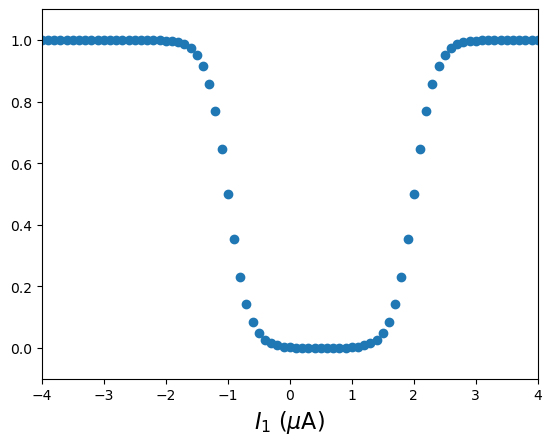

In [8]:
fig = plt.figure()
plt.scatter(X[:, 0], p_true)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.xlim(-4, 4)
plt.ylim(-0.1, 1.1)
plt.show()

In [9]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    return p_empirical

In [10]:
def fisher_info(x, w, t):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # t: number of trials for each current level, c
    
    p_model = jnp.clip(activation_probs(x, w), a_min=1e-5, a_max=1-1e-5) # c
    I_p = jnp.diag(t / (p_model * (1 - p_model)))   # c x c
    J = jax.jacfwd(activation_probs, argnums=1)(x, w).reshape((len(x), w.shape[0]*w.shape[1]))
    I_w = jnp.dot(jnp.dot(J.T, I_p), J) / len(x)
    
    loss = jnp.trace(J @ (jnp.linalg.inv(I_w) @ J.T))
    # sign, logdet = jnp.linalg.slogdet(I_w)
    # loss = -sign * logdet
    return loss

In [11]:
def optimize_fisher(x, w, t_prev, t, reg=0, step_size=0.001, n_steps=100, reltol=-np.inf, T_budget=5000, step_cnt_decrement=5):

    optimizer = optax.adamw(step_size)
    opt_state = optimizer.init(t)

    @jax.jit
    def update(x, w, t_prev, t):
        fisher_lambda = lambda t, x, w, t_prev: fisher_info(x, w, t_prev + jnp.absolute(t))  + reg * jnp.absolute(jnp.sum(jnp.absolute(t)) - T_budget)

        grads = jax.grad(fisher_lambda)(t, x, w, t_prev)

        return grads
    
    losses = []
    for step in range(n_steps):
        grads = update(x, w, t_prev, t)
        updates, opt_state = optimizer.update(grads, opt_state, params=t)
        t = optax.apply_updates(t, updates)
    
        losses += [[fisher_info(x, w, t_prev + jnp.absolute(t)), 
                    jnp.sum(jnp.absolute(t)),
                    fisher_info(x, w, t_prev + jnp.absolute(t)) + reg * jnp.absolute(jnp.sum(jnp.absolute(t)) - T_budget)]]
        

    return np.array(losses), t

In [12]:
def get_performance_AL(X, w_meas, p_true):
    probs_pred = activation_probs(X, w_meas)
    RMSE = jnp.sqrt(jnp.sum((probs_pred - p_true)**2) / len(X))

    return RMSE

Restart 1
405.0


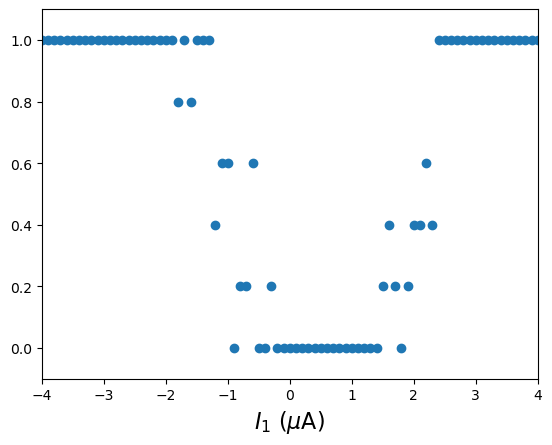

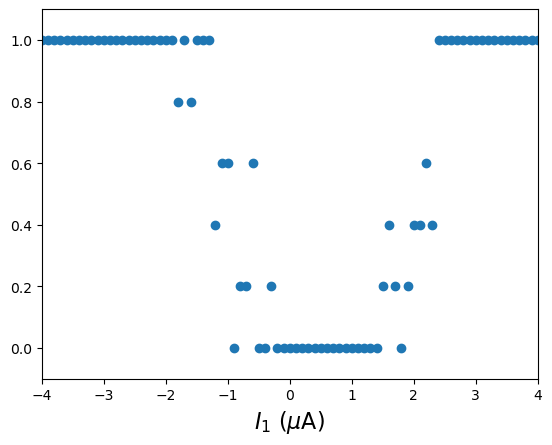

564.06726


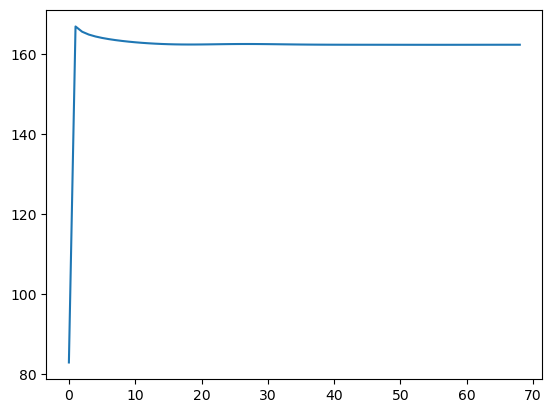

0.712112 162.3882


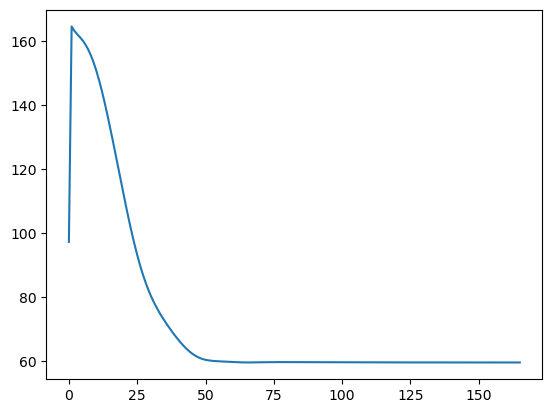

0.89442885 59.54924
[[-5.290783 -4.799903]
 [-5.290783  2.389139]]


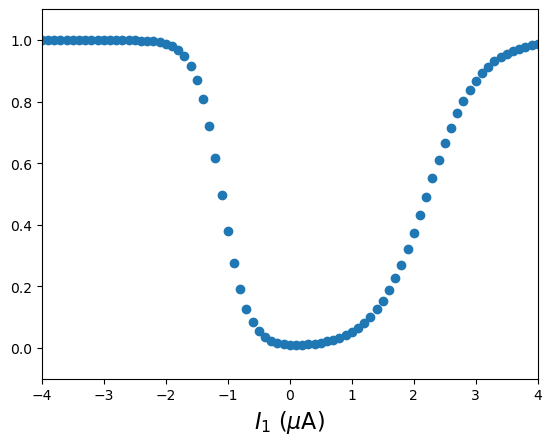

[[-5.290783 -4.799903]
 [-5.290783  2.389139]]
0.10023512 0.10023512


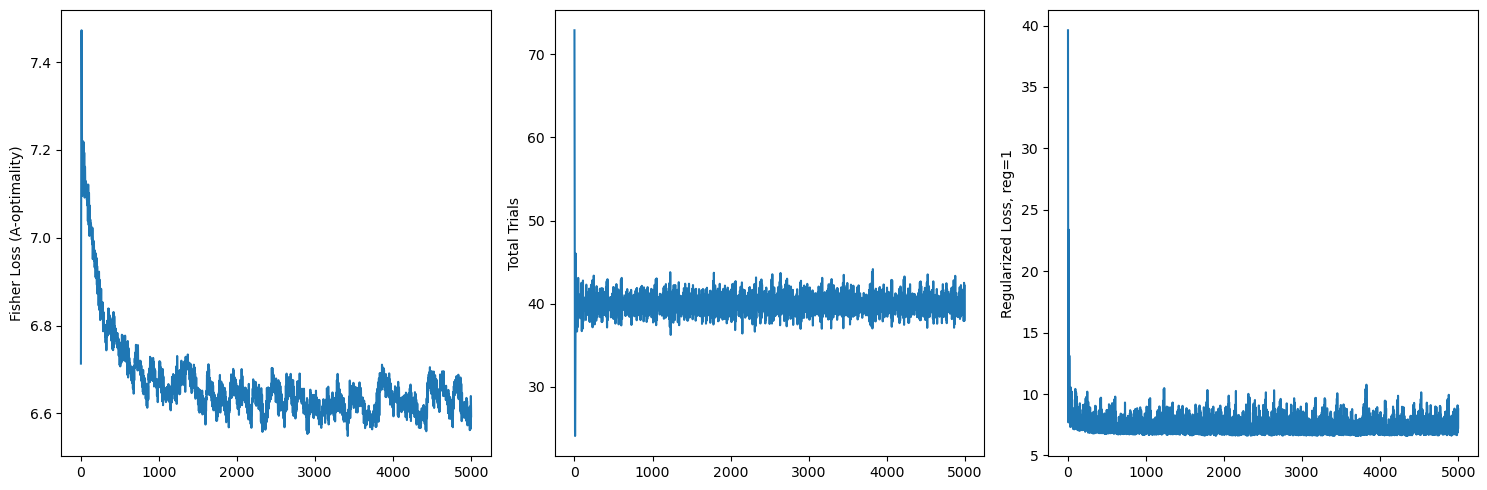

32.0


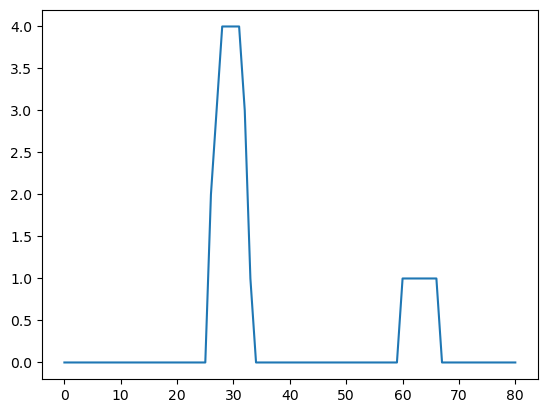

40.0


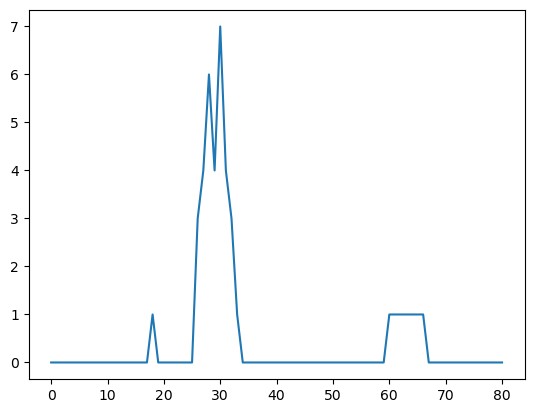

445.0


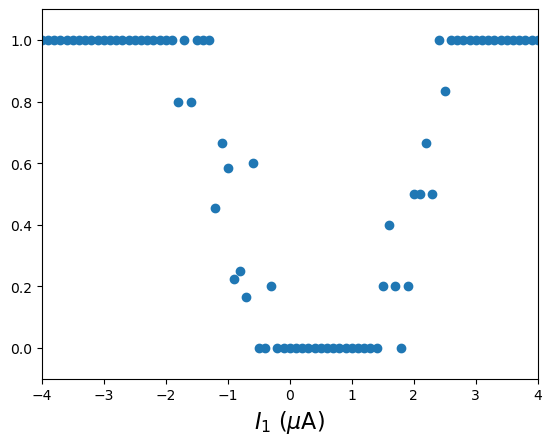

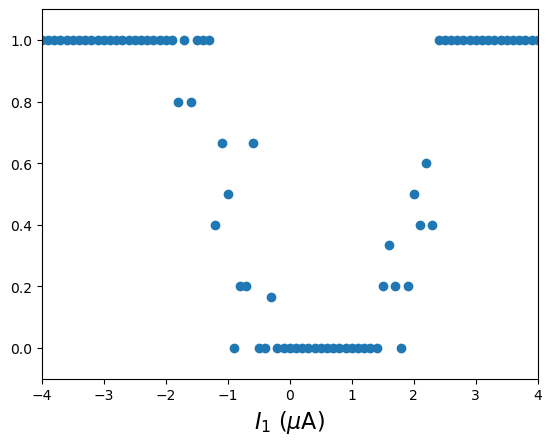

771.27563


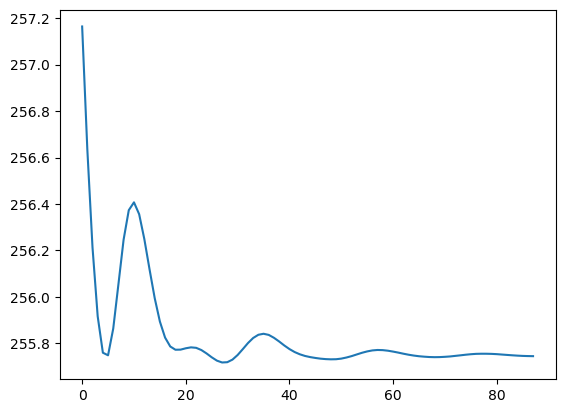

0.66841257 255.7453


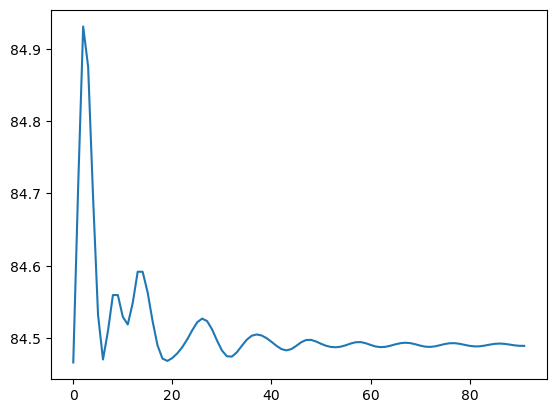

0.8904555 84.48903
[[-5.290783  -4.907795 ]
 [-5.290783   2.5453806]]


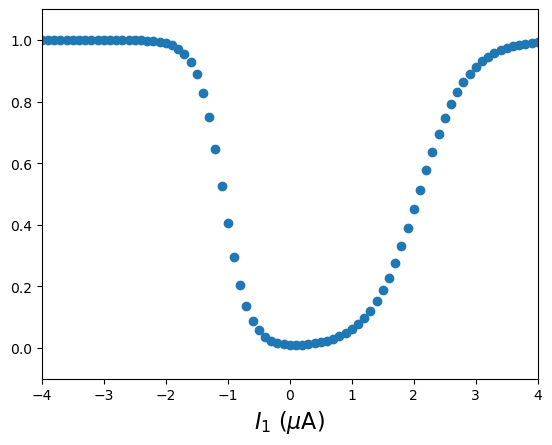

598.6019


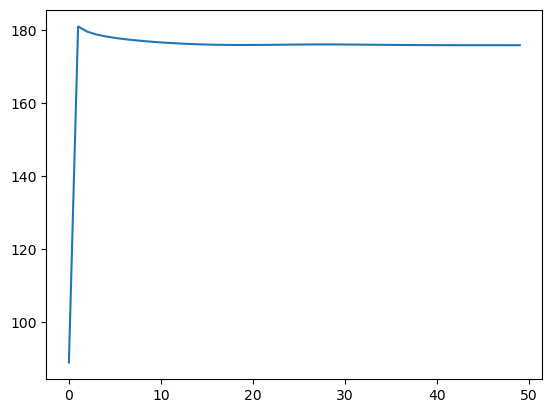

0.7063117 175.8024


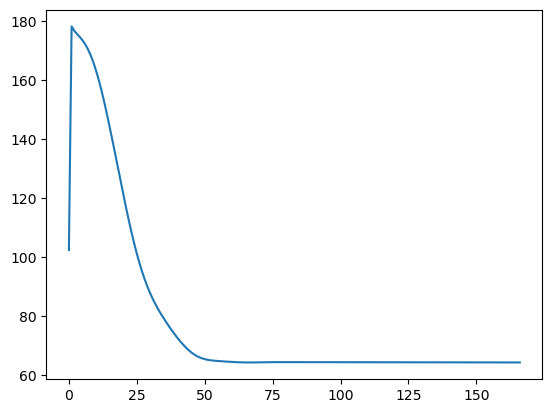

0.892483 64.359886


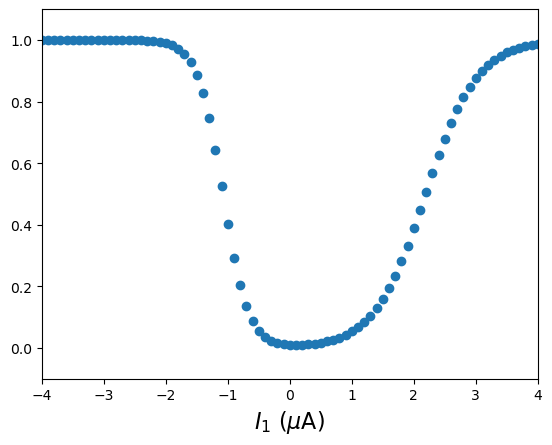

[[-5.290783 -4.897523]
 [-5.290783  2.417031]]
0.07790178 0.093593456


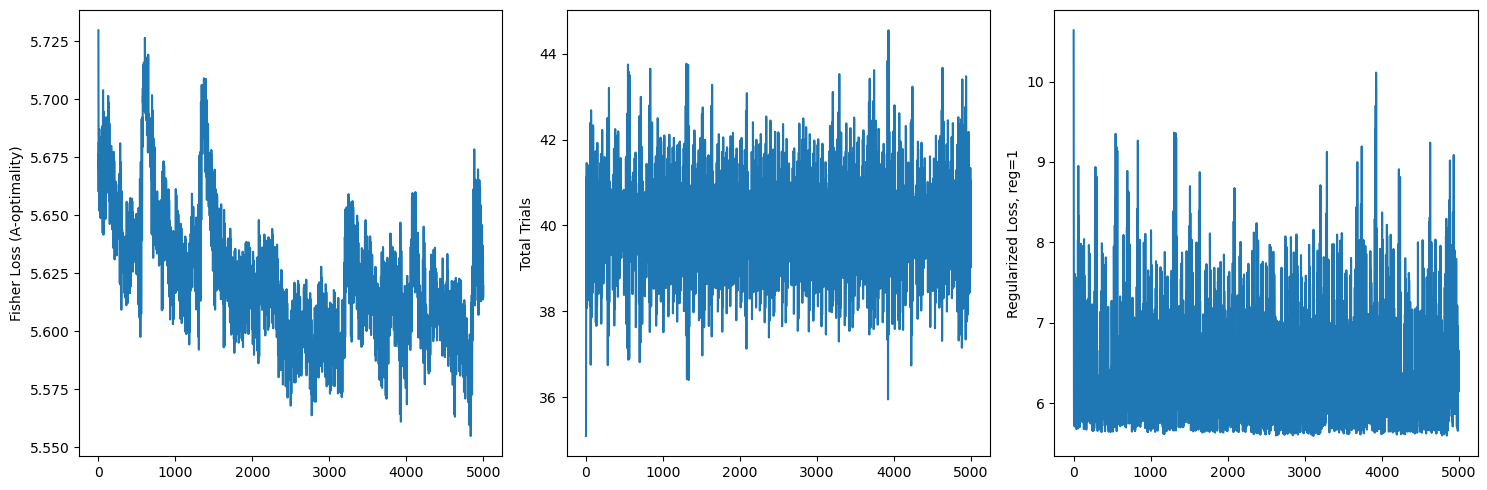

27.0


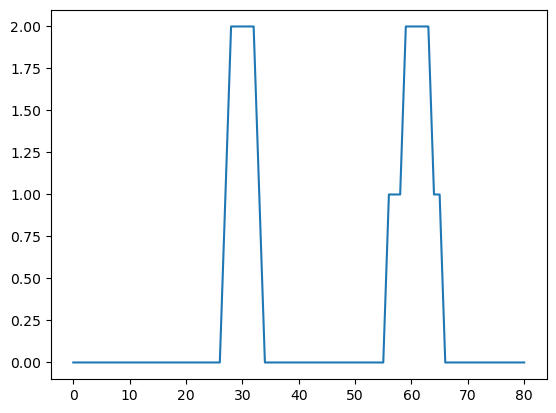

40.0


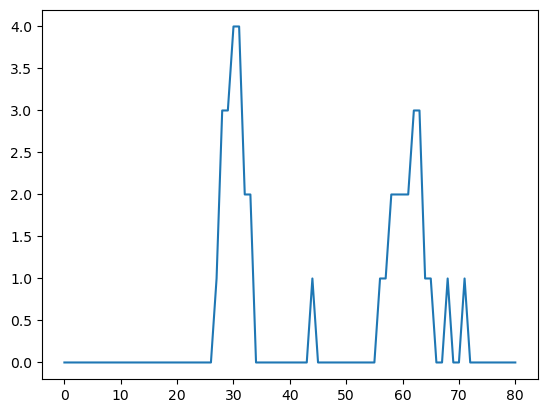

485.0


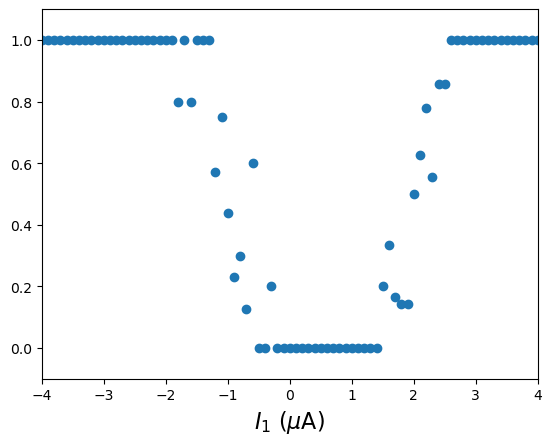

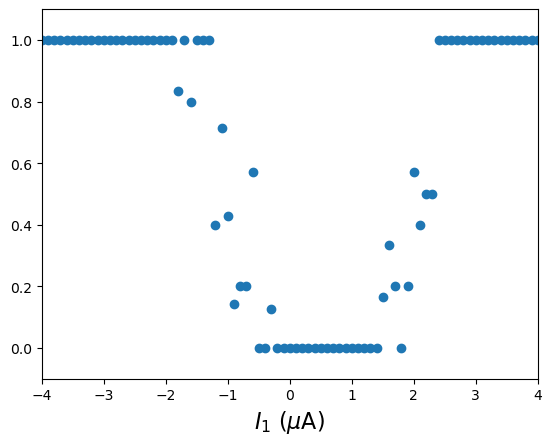

1036.042


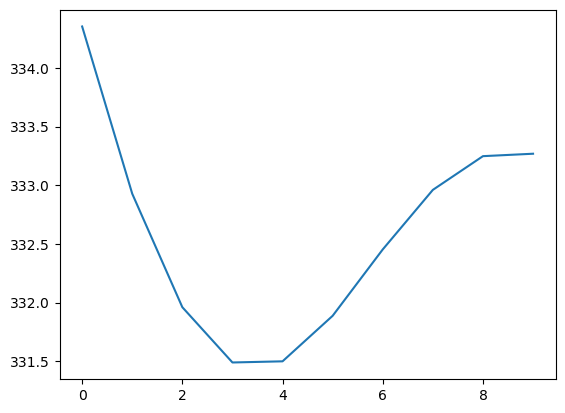

0.67832494 333.26886


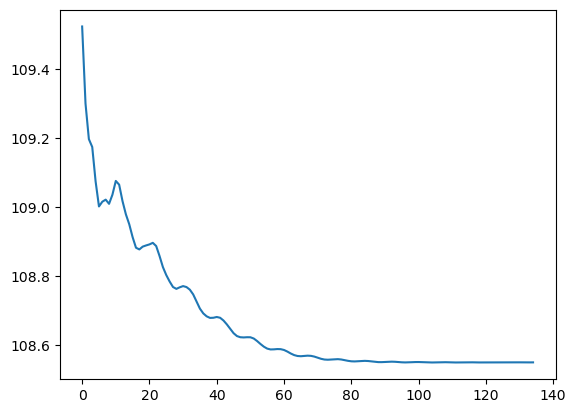

0.8952257 108.55055
[[-5.290783  -4.9901257]
 [-7.444091   3.634476 ]]


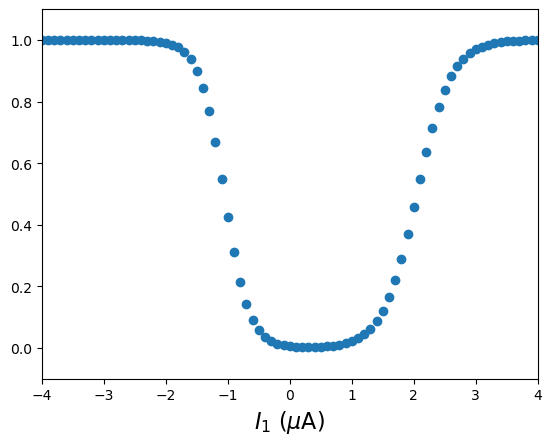

736.74084


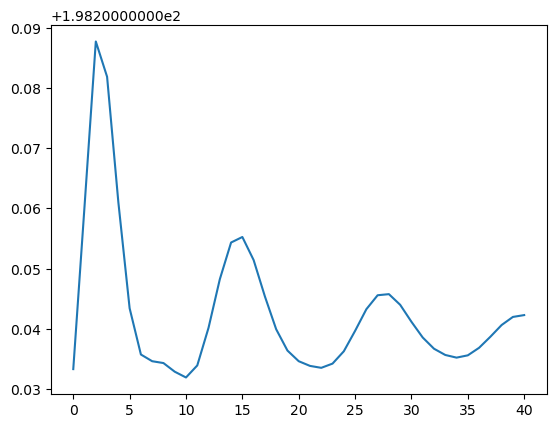

0.73091996 198.24228


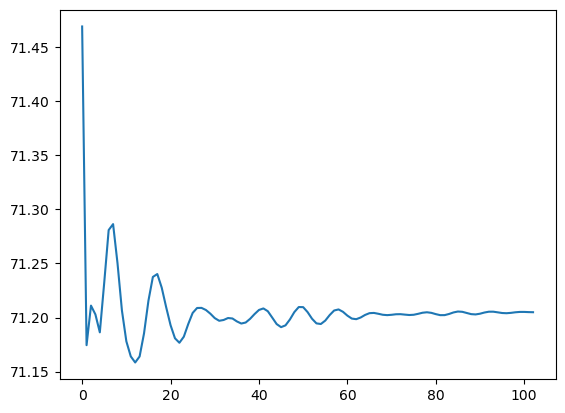

0.9033514 71.204926


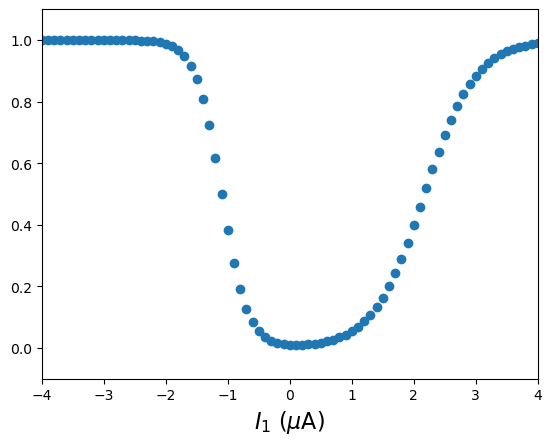

[[-5.290783  -4.8064694]
 [-5.290783   2.4397752]]
0.046759978 0.09270313


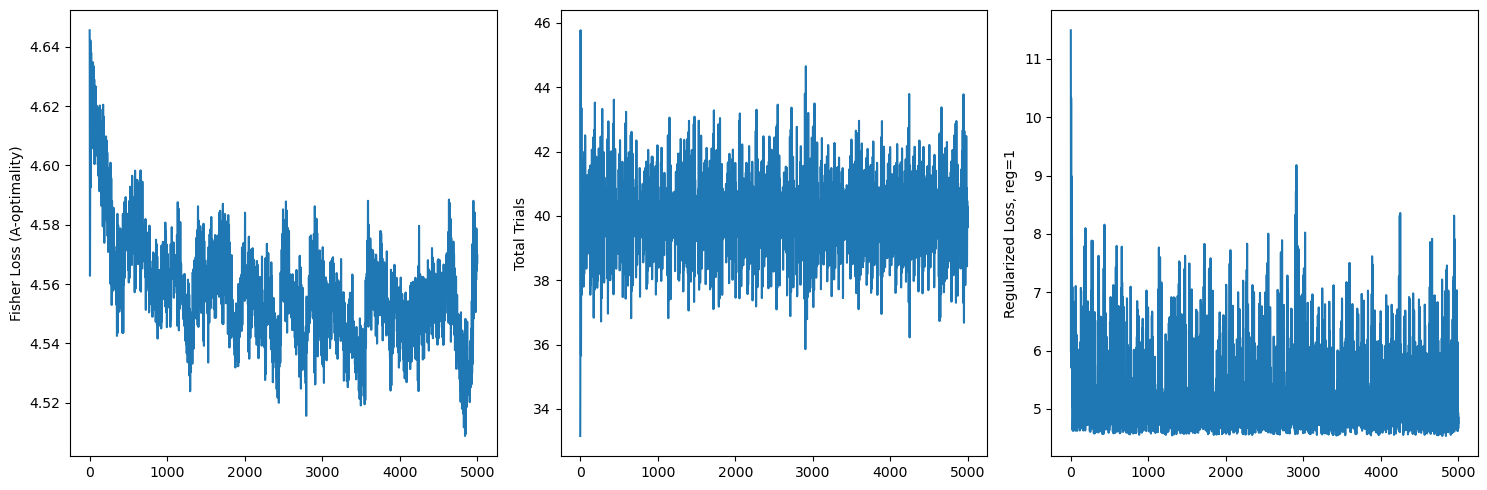

31.0


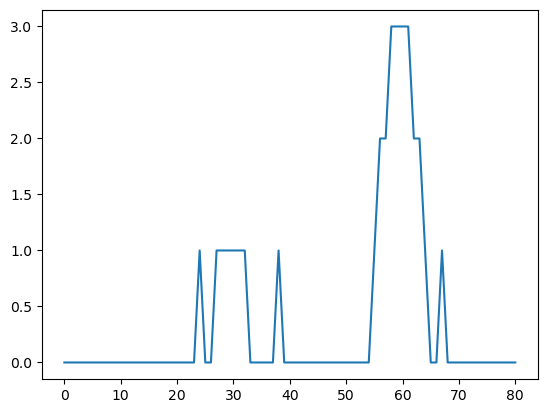

40.0


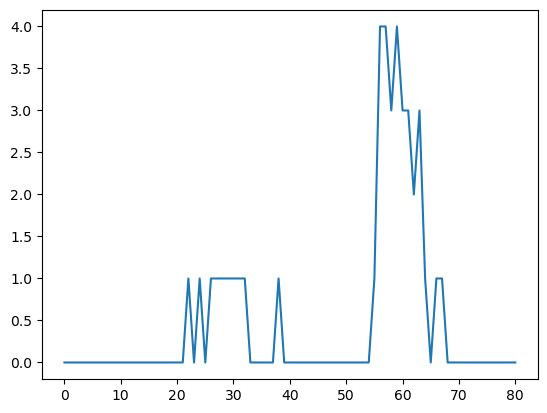

525.0


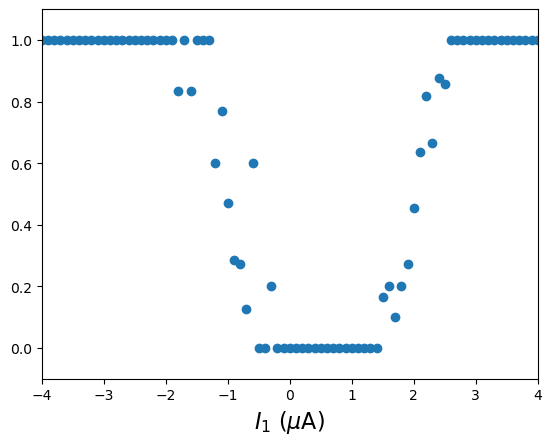

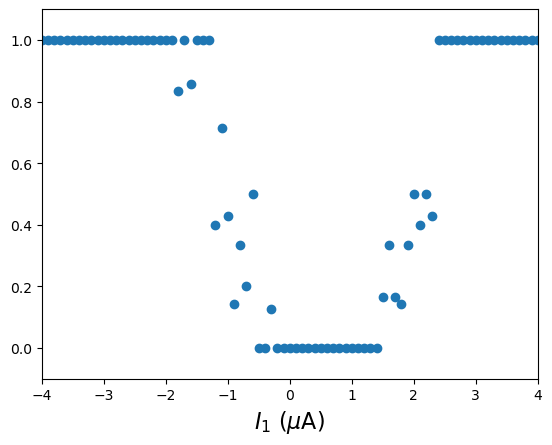

1231.7389


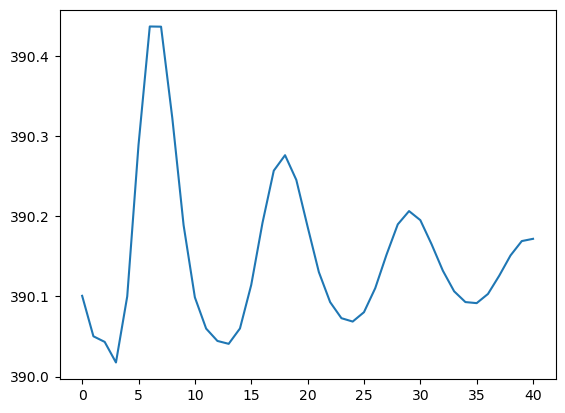

0.68323493 390.1719


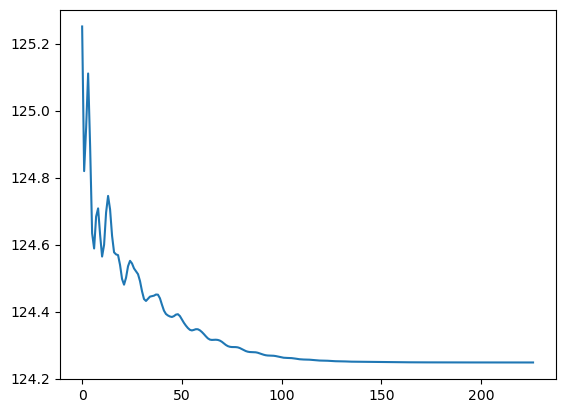

0.899128 124.24797
[[-5.290783  -5.102895 ]
 [-8.989875   4.4181275]]


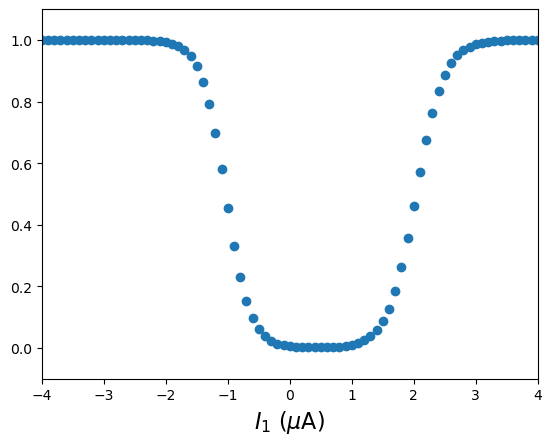

851.85657


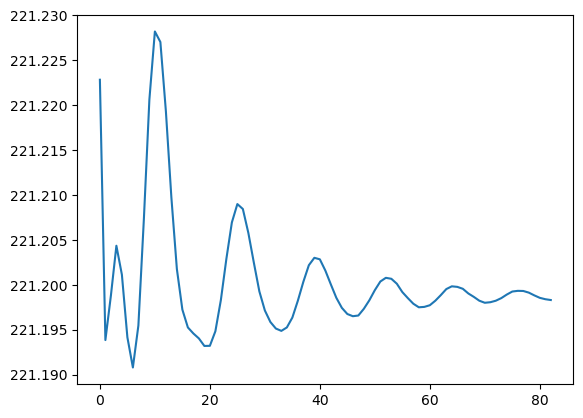

0.7403339 221.1983


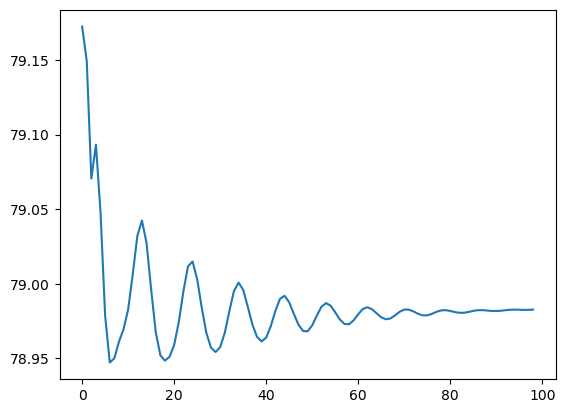

0.90728176 78.98262


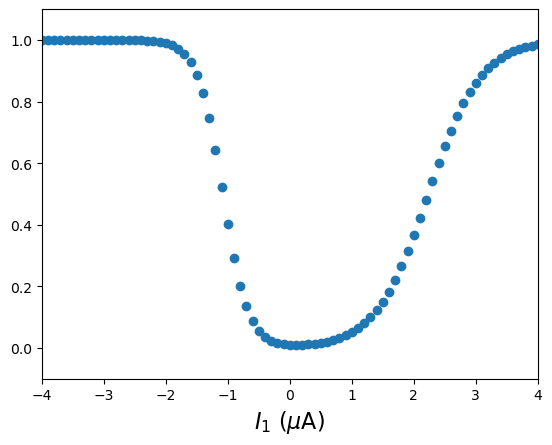

[[-5.290783  -4.896278 ]
 [-5.290783   2.3713942]]
0.029740173 0.10075248


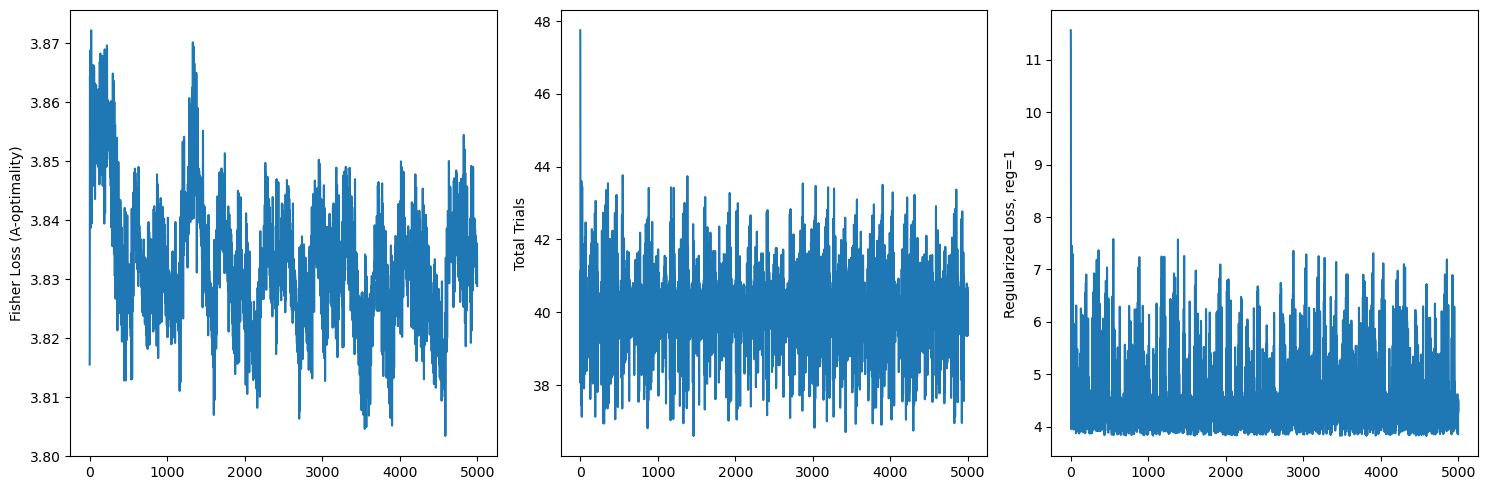

30.0


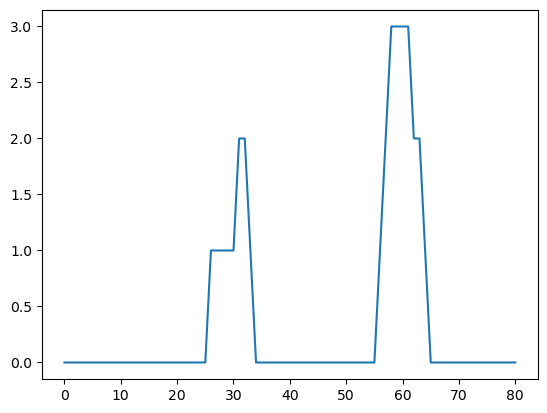

40.0


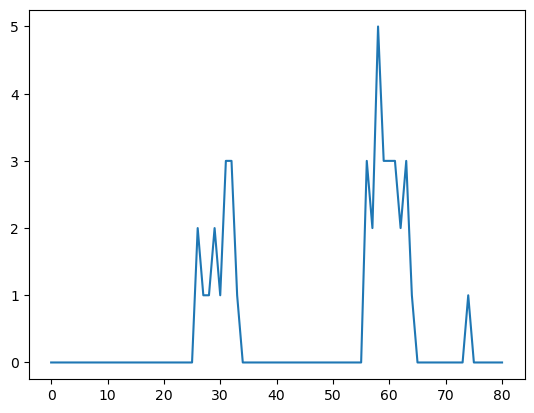

565.0


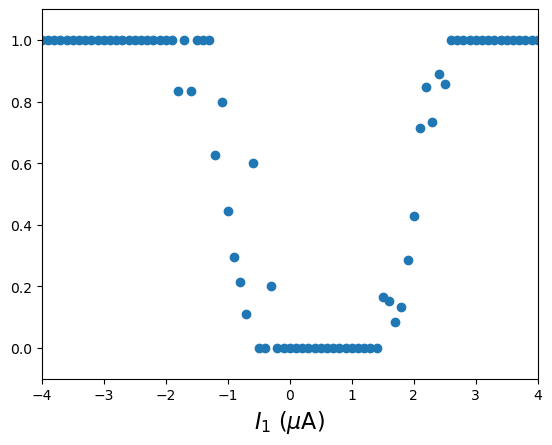

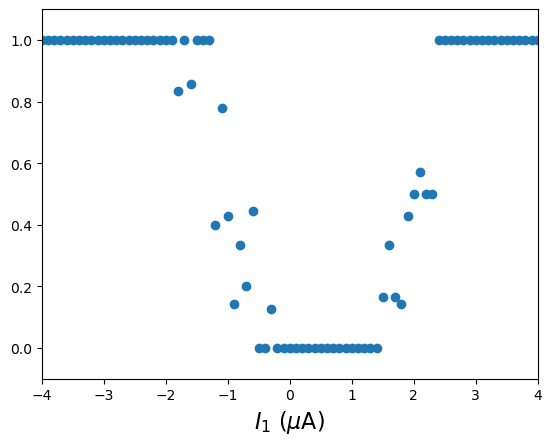

1473.4819


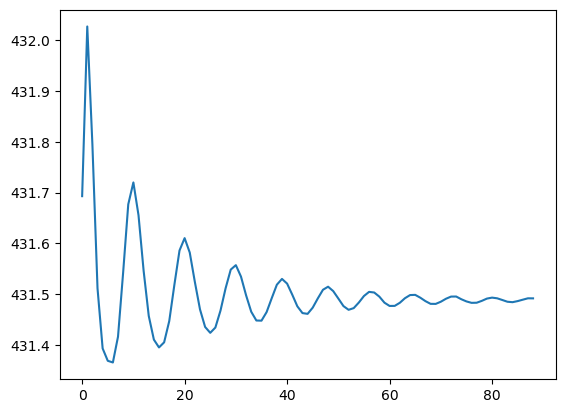

0.70716196 431.49155


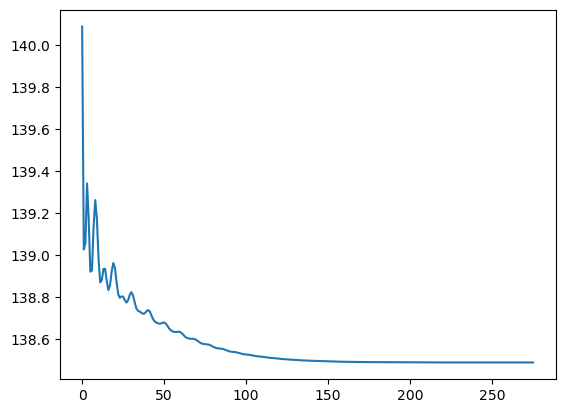

0.906012 138.48965
[[ -5.290783   -5.111772 ]
 [-10.638986    5.2435637]]


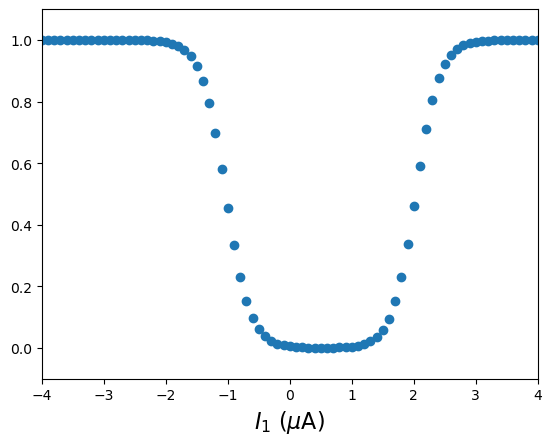

863.36816


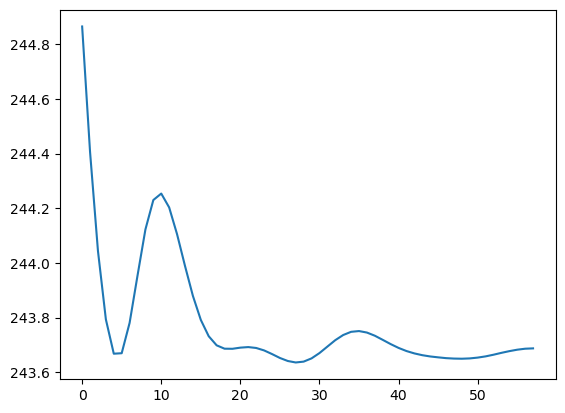

0.7177477 243.68764


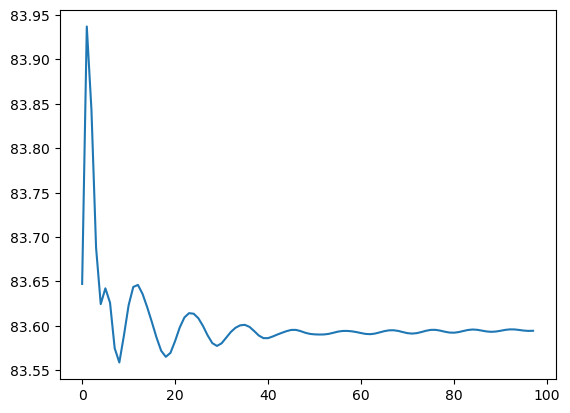

0.9031763 83.59447


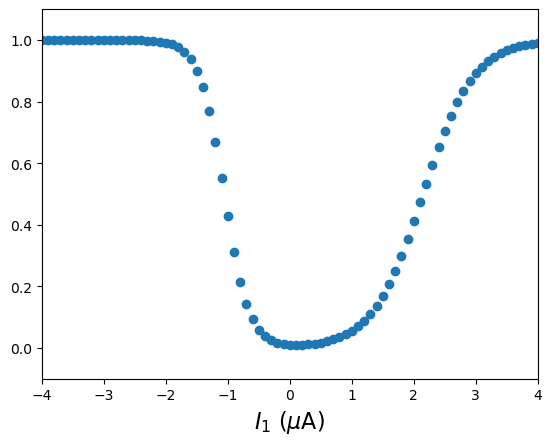

[[-5.290783  -4.995103 ]
 [-5.290783   2.4664333]]
0.021070594 0.084692605


KeyboardInterrupt: 

In [13]:
%matplotlib inline

total_budget = 200
num_iters = 5
budget = int(total_budget / num_iters)
reg = 1
num_restarts = 1
l2_reg = 0
T_step_size = 0.1 #0.01
T_n_steps = 5000
ms = [1, 2]
l2_reg = 0
w_step_size = 0.1
n_steps = 1000
R2_thresh = 0.002

init_size = 20
init_trials = 5

performance_stack = []
performance_stack_random = []
num_samples_stack = []

for restart in range(num_restarts):
    print('Restart', restart + 1)
    # Initialize amplitudes
    # init_inds = np.random.choice(len(X), replace=False, size=init_size)
    init_inds = np.arange(len(X), dtype=int)

    # Initialize trials
    T_prev = jnp.zeros(len(X_expt_orig))
    T_prev = T_prev.at[init_inds].set(init_trials)
    T_prev_random = jnp.copy(T_prev)

    p_empirical = jnp.array(sample_spikes(p_true, T_prev))
    p_empirical_random = jnp.copy(p_empirical)

    performances = []
    performances_random = []
    num_samples = []

    w_inits = []
    for m in ms:
        w_init = jnp.array(np.random.normal(size=(m, X.shape[1]+1)))
        w_inits.append(w_init)

    w_inits_random = copy(w_inits)
    cnt = 0

    while True:
        print(jnp.sum(T_prev))
        num_samples.append(np.sum(np.absolute(np.array(T_prev)).astype(int)))
        sampled_inds = np.where(np.absolute(np.array(T_prev)).astype(int) > 0)[0]

        fig = plt.figure()
        plt.scatter(X_expt_orig[sampled_inds], p_empirical[sampled_inds])
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.xlim(-4, 4)
        plt.ylim(-0.1, 1.1)
        plt.show()

        sampled_inds_random = np.where(np.absolute(np.array(T_prev_random)).astype(int) > 0)[0]

        fig = plt.figure()
        plt.scatter(X_expt_orig[sampled_inds_random], p_empirical_random[sampled_inds_random])
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.xlim(-4, 4)
        plt.ylim(-0.1, 1.1)
        plt.show()

        good_inds = jnp.where((p_empirical[sampled_inds] > 0) & (p_empirical[sampled_inds] < 1))
        X_bin, y_bin = fitting.convertToBinaryClassifier(np.array(p_empirical[sampled_inds][good_inds]), 
                                                         np.array(T_prev[sampled_inds][good_inds], dtype=int),
                                                         np.array(X[sampled_inds][good_inds]))
        X_bin = jnp.array(X_bin)
        y_bin = jnp.array(y_bin)

        w_final, w_inits =  fit_surface_McF(X_bin, y_bin, w_inits, R2_thresh=R2_thresh, 
                                            l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=True)
        
        print(w_final)

        fig = plt.figure()
        plt.scatter(X[:, 0], activation_probs(jnp.array(sm.add_constant(X, has_constant='add')), w_final))
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.xlim(-4, 4)
        plt.ylim(-0.1, 1.1)
        plt.show()

        if cnt == 0:
            T_new_init = jnp.zeros(len(T_prev)) + 1
            w_final_random = jnp.copy(w_final)
        else:
            T_new_init = t_final
            good_inds_random = jnp.where((p_empirical_random[sampled_inds_random] > 0) & (p_empirical_random[sampled_inds_random] < 1))
            X_bin, y_bin = fitting.convertToBinaryClassifier(np.array(p_empirical_random[sampled_inds_random][good_inds_random]), 
                                                         np.array(T_prev_random[sampled_inds_random][good_inds_random], dtype=int),
                                                         np.array(X[sampled_inds_random][good_inds_random]))
            X_bin = jnp.array(X_bin)
            y_bin = jnp.array(y_bin)

            w_final_random, w_inits_random =  fit_surface_McF(X_bin, y_bin, w_inits_random, R2_thresh=R2_thresh, 
                                                l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=True)

            fig = plt.figure()
            plt.scatter(X[:, 0], activation_probs(jnp.array(sm.add_constant(X, has_constant='add')), w_final_random))
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.xlim(-4, 4)
            plt.ylim(-0.1, 1.1)
            plt.show()

        print(w_final_random)

        performance = get_performance_AL(jnp.array(sm.add_constant(X, has_constant='add')), w_final, p_true)
        performances.append(performance)
        
        performance_random = get_performance_AL(jnp.array(sm.add_constant(X, has_constant='add')), w_final_random, p_true)
        performances_random.append(performance_random)

        print(performance, performance_random)
        # print('\n')

        if cnt >= num_iters:
            break
        
        losses, t_final = optimize_fisher(jnp.array(sm.add_constant(X, has_constant='add')), w_final, T_prev, T_new_init, reg=reg, step_size=T_step_size, n_steps=T_n_steps, T_budget=budget)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].plot(losses[:, 0])
        axs[0].set_ylabel('Fisher Loss (A-optimality)')
        axs[1].plot(losses[:, 1])
        axs[1].set_ylabel('Total Trials')
        axs[2].plot(losses[:, 2])
        axs[2].set_ylabel('Regularized Loss, reg=' + str(reg))

        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        plt.show()

        T_new = jnp.round(jnp.absolute(t_final), 0)#(t_final + T_new_explore), 0)
        print(jnp.sum(T_new))
        plt.figure()
        plt.plot(T_new)
        plt.show()

        if jnp.sum(T_new) < budget:
            random_extra = np.random.choice(len(X), size=int(budget - jnp.sum(T_new)), 
                                            p=np.array(jnp.absolute(t_final))/np.sum(np.array(jnp.absolute(t_final))))
            T_new_extra = jnp.array(np.bincount(random_extra, minlength=len(X))).astype(int)
            T_new = T_new + T_new_extra
            
            print(jnp.sum(T_new))
            plt.figure()
            plt.plot(T_new)
            plt.show()

        p_new = jnp.array(sample_spikes(p_true, T_new))

        p_tmp = (p_new * T_new + p_empirical * T_prev) / (T_prev + T_new)
        T_tmp = T_prev + T_new
        p_tmp = p_tmp.at[jnp.isnan(p_tmp)].set(0.5)

        p_empirical = p_tmp
        T_prev = T_tmp

        # print(jnp.sum(T_tmp))

        random_draws = np.random.choice(len(X), size=int(jnp.sum(T_new)))
        T_new_random = jnp.array(np.bincount(random_draws, minlength=len(X))).astype(int)
        p_new_random = jnp.array(sample_spikes(p_true, T_new_random))
        
        p_tmp_random = (p_new_random * T_new_random + p_empirical_random * T_prev_random) / (T_prev_random + T_new_random)
        T_tmp_random = T_prev_random + T_new_random
        p_tmp_random = p_tmp_random.at[jnp.isnan(p_tmp_random)].set(0.5)

        p_empirical_random = p_tmp_random
        T_prev_random = T_tmp_random

        cnt += 1

        # input()
    
    performance_stack.append(performances)
    performance_stack_random.append(performances_random)
    num_samples_stack.append(num_samples)

In [ ]:
# savemat('sampling_map_p3_n296.mat', {'X': np.array(X_expt_orig),
#                                      'p_empirical': np.array(p_empirical),
#                                      'sampled_inds': np.array(sampled_inds), 
#                                      'T': np.array(T_prev),
#                                      'init_inds': init_inds})

In [ ]:
fig = plt.figure()
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.xlim(-4, 4)

T_prev_tmp = T_prev.at[init_inds].set(T_prev[init_inds]-init_trials)
sampled_inds_tmp = np.where(np.absolute(np.array(T_prev_tmp)).astype(int) > 0)[0]
plt.plot(X_expt_orig[sampled_inds_tmp], T_prev_tmp[sampled_inds_tmp])
plt.show()

In [ ]:
# savemat('performances_5step_p2_n259_adamw.mat', {'performance_stack': np.array(performance_stack),
#                                                 'performance_stack_random': np.array(performance_stack_random)})

In [ ]:
%matplotlib inline

plt.figure(figsize=(10, 8))
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack), 0), 
             yerr=np.std(np.array(performance_stack), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Active Learning', c='tab:blue', alpha=0.3)
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack_random), 0), 
             yerr=np.std(np.array(performance_stack_random), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Random Baseline', c='tab:orange', alpha=0.3)

# plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Trials Sampled', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)
# plt.ylim(0.36, 0.4)

# plt.savefig('performances_5step_p2_n259_adamw.png', dpi=300)

In [ ]:
w_true_t, w_true_nt

In [ ]:
all_combos = fitting.all_combos(np.arange(len(cells)))
ws_full = []
for i in range(len(cells)):
    ws_full.append(np.array(ws[i]))

ws_active = []
ws_active += [np.array(w_final_t)]
ws_active += [np.array(w_final_nt)]

for j in all_combos:
    combo = np.array(j)
    if len(combo) != 0 and len(combo) != len(cells):
        targets = combo
        selectivities_full.append(fitting.selectivity_triplet(ws_full, targets))
        selectivities_active.append(fitting.selectivity_triplet(ws_active, targets))
        datasets.append((dataset, wnoise, estim, p, cells, cells[targets]))

In [ ]:
selectivities_full, selectivities_active

In [ ]:
datasets

In [ ]:
x = np.array(selectivities_full)[:, 1]
y = np.vstack((np.array(selectivities_full)[:, 0], np.array(selectivities_active)[:, 0])).T

lines = []
for i, j in zip(x, y):
    pair = [(i, j[0]), (i, j[1])]
    lines.append(pair)

linecoll = matcoll.LineCollection(lines, colors='k')

fig, ax = plt.subplots()
ax.plot(x, [i for (i,j) in y], 's', c='tab:blue', markersize = 10, alpha=0.8, label='Full Dataset')
ax.plot(x, [j for (i,j) in y], 'o', c='tab:red', markersize = 10, alpha=0.8, label='Subsampled Dataset')
ax.add_collection(linecoll)
ax.plot(np.linspace(-0.01, 1.01, 100), np.linspace(-0.01, 1.01, 100), linestyle='--', c='k')
ax.set_xlabel('Single-Electrode Selectivity', fontsize=22)
ax.set_ylabel('Triplet Selectivity', fontsize=22)
ax.tick_params('both', labelsize=18)
ax.legend(fontsize=16)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig('fig2_NER.png', dpi=300)

In [ ]:
np.save('selectivities_full.npy', np.array(selectivities_full))
np.save('selectivities_active.npy', np.array(selectivities_active))
np.save('datasets.npy', np.array(datasets, dtype=object))